## 时间序列的预测

前面我们已经完成了对各种状态空间时间序列的参数，下面将介绍另外一个极其重要的方面：预测。在预测时，状态变量$\alpha_t$起着关键作用，考虑第一节的状态空间模型，如果我们想要预测h步之后的y，可以通过如下递推关系获得：
\begin{equation}
\label{eq:forecast}
\begin{split}
\hat{y}_{t+1}=z a_t=z(c+w a_{t-1}+k v_{t})\\
\\
\hat{y}_{t+2}=z*a_{t+1}=z*(c+w*a_{t})=z*c+w*\hat{y}_{t+1}\\
\\
\hat{y}_{t+3}=z*a_{t+2}=z*(c+w*a_{t+1})=z*c+w*\hat{y}_{t+2}\\
\\
\hat{y}_{t+4}=z*a_{t+3}=z*(c+w*a_{t+2})=z*c+w*\hat{y}_{t+3}\\
\vdots\\
\hat{y}_{t+h}=z*c+w*\hat{y}_{t+h-1}\\
\end{split}
\end{equation}


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

例如考虑如下Theta method序列：

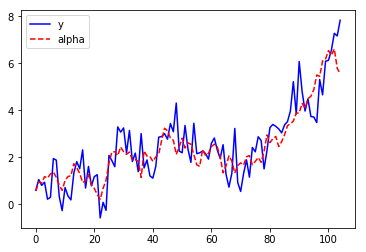

In [2]:
n=105
np.random.seed(1347)
su=.1
se=.5
co=.06
e=np.sqrt(se)*np.random.randn(n)
u=np.sqrt(su)*np.random.randn(n)
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=e[0]
alpha[0]=u[0]
for t in range(1,n):
  y[t]=alpha[t-1]+e[t]
  alpha[t]=alpha[t-1]+u[t]+co
plt.plot(y,'b',label="y")
plt.plot(alpha,'r--',label="alpha")
plt.legend()
plt.show()  

假设我们现在只观测到前100个数据，后5个数据未知，如果我们需要预测未来5天的数据，就需要首先估计状态空间模型的参数，然后按照上述递推公式进行预测。

首先我们对参数进行估计：

In [3]:
n=100
x=y[0:100]
a=np.zeros(n)
p=np.zeros(n)
a[0]=x[0]
p[0]=10000
k=np.zeros(n)
v=np.zeros(n)
def funTheta(mypa):
    q=abs(mypa[0])
    co=abs(mypa[1])
    z=1
    w=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=x[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood
res=optimize.minimize(funTheta,[0.6,0.2])
print("极大似然估计所得结果：",res.x)
trueparam=[su/se,co]
print("真实参数：",trueparam)

极大似然估计所得结果： [ 0.40119447  0.0455639 ]
真实参数： [0.2, 0.06]


In [4]:
z=1
w=1
sigmae=0
q=abs(res.x[0])
co=abs(res.x[1])
for t in range(1,n):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=x[t]-z*a[t-1]
    a[t]=co+w*a[t-1]+k[t]*v[t]
    sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
print("e的估计方差：",sigmae/(n-1),';e的真实方差：',se)
print("u的估计方差：",q*(sigmae/(n-1)),';u的真实方差：',su)

e的估计方差： 0.374945602492 ;e的真实方差： 0.5
u的估计方差： 0.150426101029 ;u的真实方差： 0.1


现在我们可以利用估计得到的参数进行预测：

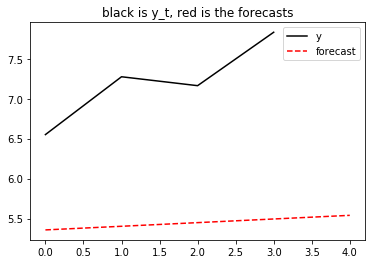

In [7]:
MyForecasts=np.zeros(5)
MyForecasts[0]=a[n-1]
MyForecasts[1]=co+MyForecasts[0]
MyForecasts[2]=co+MyForecasts[1]
MyForecasts[3]=co+MyForecasts[2]
MyForecasts[4]=co+MyForecasts[3]
plt.plot(y[101:105],'black',label='y')
plt.plot(MyForecasts,'r--',label='forecast')
plt.title('black is y_t, red is the forecasts')
plt.legend()
plt.show()

### 含季节性因素的时间序列的预测：

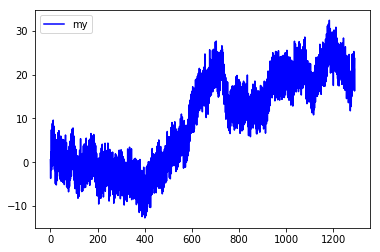

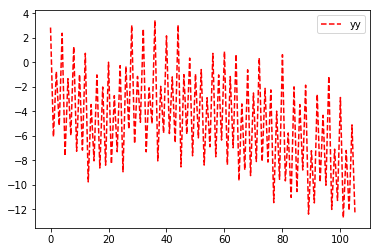

In [31]:
n=1293
np.random.seed(4241)
su=.1
se=.4
h=6
e=np.sqrt(se)*np.random.randn(n)
u=np.sqrt(se)*np.random.randn(n)
my=np.zeros(n)
alpha=np.zeros(n)
seasfactor=[5,-4,2,-3]
s=4
con=.03
seasonal=(seasfactor*int(np.ceil(n/s)))[0:n]
my[0]=e[0]
alpha[0]=u[0]
for t in range(1,n):
    my[t]=seasonal[t]+alpha[t-1]+e[t]
    alpha[t]=alpha[t-1]+u[t]
yy=my[300:406]
plt.plot(my,'b',label="my")
plt.legend()
plt.show()  
plt.plot(yy,'r--',label="yy")
plt.legend()
plt.show()  

对于这种时间序列，预测的过程如下：

（1）用先前讨论的additive或multiplicative 的方法将季节性因素提取出来；

（2）使用合适的状态空间模型对去掉季节性因素之后的序列进行预测；

（3）将预测值加上或乘以季节性因素得到最终预测值。

相加或相乘过程取决于我们观察到的季节性类型。 如果随着时间序列推移，季节性成分被放大，我们将使用乘法过程。 另一方面，如果季节性分量是恒定的，并且没有随着时间增加，则使用加法过程。

在该例子中，我们假设已知前100个数据，留下最后6个做预测。

In [38]:
y=yy[0:(len(yy)-h)]
s=4
n=len(y)
w=[1/(2*s)]*(s+1)
for i in range(1,s):
    w[i]=1/s   # 生成移动平均的权重
cma=np.full([len(y),1], np.nan)   # 生成中心移动平均向量
for i in range(len(y)-s):
    cma[int(i+s/2)]=float(np.dot(w,y[i:i+s+1]))  # 计算中心移动平均向量
residuals=y/cma.reshape(1,len(y))     # 残差
factors=[0]*s
for seas in range(s):
    factors[seas]=np.mean(residuals[0][seas:len(y)-s+seas+1:s][~np.isnan(residuals[0][seas:len(y)-s+seas+1:s])])
for i in range(s):
    factors[i]=factors[i]/np.mean(factors)
# factors=(factors-[np.mean(factors)]*s)
newseries=np.array(y)/np.array((factors*int(np.ceil(n/s)))[0:n])

现在我们即可对消除季节性的时间序列进行预测，然后再乘上季节性因素即可得到最终的预测值。

In [39]:
a=np.zeros(n)
p=np.zeros(n)
a[0]=newseries[0]
p[0]=10000
k=np.zeros(n)
v=np.zeros(n)
def funTheta(mypa):
    q=abs(mypa[0])
    co=abs(mypa[1])
    z=1
    w=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=newseries[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood
res=optimize.minimize(funTheta,[0.6,0.2],method='TNC')
print("极大似然估计所得结果：",res.x)

极大似然估计所得结果： [ -5.67302871e-11  -5.46633088e-03]


In [40]:
z=1
w=1
sigmae=0
q=abs(res.x[0])
co=abs(res.x[1])
for t in range(1,n):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=y[t]-z*a[t-1]
    a[t]=co+w*a[t-1]+k[t]*v[t]
    sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
print("const的估计结果：",co)
print("sigmae的估计结果：",sigmae/(len(newseries)-1))
print("sigmau的估计结果：",q*(sigmae/(len(newseries)-1)))

const的估计结果： 0.00546633088349
sigmae的估计结果： 17.3093975864
sigmau的估计结果： 9.81967095203e-10


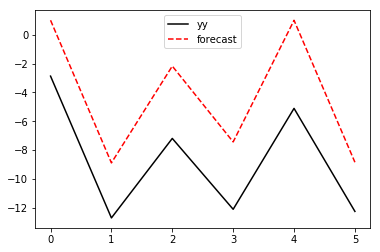

In [44]:
sfactnh=(factors*int(np.ceil((n+h)/s)))[0:n+h]
sfactout=sfactnh[(len(sfactnh)-h):len(sfactnh)]
w=1
z=1
MyForecasts=np.zeros(h)
MyForecasts[0]=a[len(newseries)-1]
for i in range(1,h):
    MyForecasts[i]=co+MyForecasts[i-1]
SeasonalForecast=MyForecasts*sfactout
plt.plot(yy[(len(yy)-h):len(yy)],'black',label='yy')
plt.plot(SeasonalForecast,'r--',label='forecast')
plt.legend()
plt.show()

### 预测性能的比较

假设我们需要比较两个模型在预测一个特定时间序列时的性能，一个很重要的问题是要建立一个评价准则，从而可以判断那个模型表现地更好。两个常用的准测是平均绝对误差(MASE)和平均相对误差(MAPE)。如果将未来的真实序列值记为$y_{t+1}\;y_{t+2}\;\cdots\;y_{t+h}$，将预测值记为$\hat{y}_{t+1}\;\hat{y}_{t+2}\;\cdots\;\hat{y}_{t+h}$，那么(MASE)和(MAPE)可以如下表示：
\begin{equation}
\label{eq:MASEsMAPE}
\begin{split}
MASE=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h} |y_t-\hat{y}_t|}{\frac{1}{n-m}\sum_{t=m+1}^{n}|y_t-y_{t-m}|}\\
MAPE=\frac{2}{h}\sum_{t=n+1}^{n+h} \frac{|y_t-\hat{y}_t|}{|y_t|+|\hat{y}_t|} \times 100,
\end{split}
\end{equation}

假设我们现在想预测意大利Lombardy地区（意大利感染最严重的地区）新冠肺炎的新增数量，我们采用Theta method模型进行预测。还是留下最后5天的观测值作为未知进行预测。

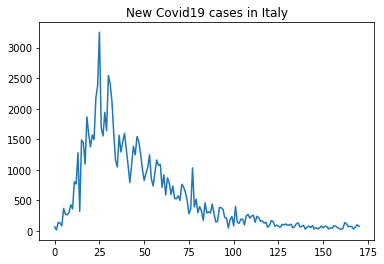

In [16]:
newcase=np.loadtxt('Italy newcase.csv',delimiter=',')
plt.plot(newcase)
plt.title('New Covid19 cases in Italy')
plt.show()

In [18]:
obs=len(newcase)-5
x=newcase[0:obs]
a=np.zeros(obs)
p=np.zeros(obs)
a[0]=x[0]
p[0]=10000
k=np.zeros(obs)
v=np.zeros(obs)
def funTheta(mypa):
    q=abs(mypa[0])
    co=abs(mypa[1])
    z=1
    w=1
    likelihood=0
    sigmae=0
    for t in range(1,obs):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=x[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*obs*np.log(sigmae/obs) 
    return likelihood
res=optimize.minimize(funTheta,[0.6,0.2],method='TNC')
print("极大似然估计所得结果：",res.x)
z=1
w=1
sigmae=0
q=abs(res.x[0])
co=res.x[1]
for t in range(1,obs):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=x[t]-z*a[t-1]
    a[t]=co+w*a[t-1]+k[t]*v[t]
    sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
print("const的估计结果：",co)
print("sigmae的估计结果：",sigmae/(len(newcase)-1))
print("sigmau的估计结果：",q*(sigmae/(len(newcase)-1)))

极大似然估计所得结果： [  5.59080168e-01   5.01334343e-09]
const的估计结果： 5.01334343483e-09
sigmae的估计结果： 30182.7473536
sigmau的估计结果： 16874.575447


下面进行预测：

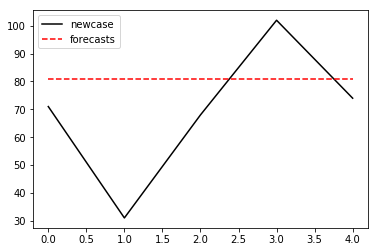

In [19]:
MyForecasts=np.zeros(5)
MyForecasts[0]=a[obs-1]
MyForecasts[1]=co+MyForecasts[0]
MyForecasts[2]=co+MyForecasts[1]
MyForecasts[3]=co+MyForecasts[2]
MyForecasts[4]=co+MyForecasts[3]
plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(MyForecasts,'r--',label='forecasts')
plt.legend()
plt.show()

接下来我们计算用Theta method估计预测意大利新增病例的MASE和MAPE：

In [21]:
MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-MyForecasts))/np.mean(abs(np.diff(x)))
MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-MyForecasts)/
             (abs(MyForecasts)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
print('MASE=',MASE)
print('MAPE=',MAPE)

MASE= 0.123444165977
MAPE= 30.3700452651


现在我们用单噪声源的Local level来预测，将最后的预测效果和上述方法进行对比。

极大似然估计所得结果： [ 0.50250551]


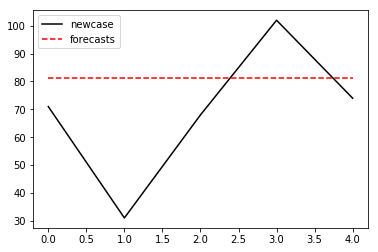

In [22]:
a=np.zeros(obs)
a[0]=x[0]
v=np.zeros(obs)
def EstimateSS(mypa):
    gamma=mypa
    for t in range(1,obs):
        v[t]=x[t]-a[t-1]
        a[t]=a[t-1]+gamma*v[t]
    return np.sum(v[1:obs-1]**2)/obs
res=optimize.minimize(EstimateSS,[0.1],method="TNC",bounds =[(0,1)])
print("极大似然估计所得结果：",res.x)
a=np.zeros(obs)
v=np.zeros(obs)
a[0]=x[0]
gamma=res.x[0]
for t in range(1,obs):
    v[t]=x[t]-a[t-1]
    a[t]=a[t-1]+gamma*v[t]
LLForecasts=np.zeros(5)
LLForecasts[0]=a[obs-1]
LLForecasts[1]=LLForecasts[0]
LLForecasts[2]=LLForecasts[1]
LLForecasts[3]=LLForecasts[2]
LLForecasts[4]=LLForecasts[3]
plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(LLForecasts,'r--',label='forecasts')
plt.legend()
plt.show()

In [24]:
ThetaMASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-MyForecasts))/np.mean(abs(np.diff(x)))
ThetaMAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-MyForecasts)/
             (abs(MyForecasts)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
print('ThetaMASE=',ThetaMASE)
print('ThetaMAPE=',ThetaMAPE)
LLMASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-LLForecasts))/np.mean(abs(np.diff(x)))
LLMAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-LLForecasts)/
             (abs(LLForecasts)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
print('LLMASE=',LLMASE)
print('LLMAPE=',LLMAPE)

ThetaMASE= 0.123444165977
ThetaMAPE= 30.3700452651
LLMASE= 0.124070021362
LLMAPE= 30.4878806976


从结果可以看出，如果以MASE为标准，则Local leve比Theta method略好一些；如果以MAPE为标准，则Theta method比Local level略好一些。

### 预测性能竞争

假设我们有一个时间序列数据集，需要用上面的MASE和MAPE方法比较各种模型之间的预测性能，下面我们对比五个模型：多噪声源状态空间模型、单噪声源状态空间模型、多噪声源Theta method模型、单噪声源Theta method模型、单噪声源dampened trend模型。

In [31]:
def ForecastKFMS(y,h):
    
    # 多噪声源状态空间模型的预测
    
    n=len(y)
    a=np.zeros(n)
    p=np.zeros(n)
    a[0]=y[0]
    p[0]=10000
    k=np.zeros(n)
    v=np.zeros(n)
    def function(mypa):
        q=abs(mypa[0])
        co=abs(mypa[1])
        w=1-np.exp(-abs(mypa[2]))
        z=1
        likelihood=0
        sigmae=0
        for t in range(1,n):
            k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
            p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
            v[t]=y[t]-z*a[t-1]
            a[t]=co+w*a[t-1]+k[t]*v[t]
            sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
            likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
        likelihood+=.5*n*np.log(sigmae/n) 
        return likelihood
    res=optimize.minimize(function,[.2,1,1])
    v=np.zeros(n)
    z=1
    q=abs(res.x[0])
    co=abs(res.x[1])
    w=1-np.exp(-abs(res.x[2]))
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
    Forecasts=np.zeros(h)
    Forecasts[0]=a[len(y)-1]
    for i in range(1,h):
        Forecasts[i]=co+w*Forecasts[i-1]
    return Forecasts

In [26]:
def ForecastKFSS(y,h):
    
    # 单噪声源状态空间模型的预测
    
    n=len(y)
    state=np.zeros(n)
    state[0]=y[0]
    v=np.zeros(n)
    def logLikConc(mypa):
        co=abs(mypa[2])
        gamma=abs(mypa[1])
        w=1-np.exp(-abs(mypa[0]))
        for t in range(1,n):
            v[t]=y[t]-state[t-1]
            state[t]=co+w*state[t-1]+gamma*v[t]
        return np.sum(v[1:(n-1)]**2)
    res=optimize.minimize(logLikConc,[1,.2,1])
#     v=np.zeros(n)
    co=abs(res.x[2])
    gamma=abs(res.x[1])
    w=1-np.exp(-abs(res.x[0]))
    for t in range(1,n):
        v[t]=y[t]-state[t-1]
        state[t]=co+w*state[t-1]+gamma*v[t]
    Forecasts=np.zeros(h)
    Forecasts[0]=state[len(y)-1]
    for i in range(1,h):
        Forecasts[i]=co+w*Forecasts[i-1]
    return Forecasts

In [27]:
def ForecastThetaSS(y,h):
    
    # 单噪声Theta method模型的预测
    
    n=len(y)
    state=np.zeros(n)
    state[0]=y[0]
    v=np.zeros(n)
    def logLikConc(mypa):
        co=abs(mypa[1])
        gamma=abs(mypa[0])
        w=1
        for t in range(1,n):
            v[t]=y[t]-state[t-1]
            state[t]=co+w*state[t-1]+gamma*v[t]
        return np.sum(v[1:(n-1)]**2)
    res=optimize.minimize(logLikConc,[.3,1])
#     v=np.zeros(n)
    co=abs(res.x[1])
    gamma=abs(res.x[0])
    w=1
    for t in range(1,n):
        v[t]=y[t]-state[t-1]
        state[t]=co+w*state[t-1]+gamma*v[t]
    Forecasts=np.zeros(h)
    Forecasts[0]=state[n-1]
    for i in range(1,h):
        Forecasts[i]=co+w*Forecasts[i-1]
    return Forecasts

In [33]:
def ForecastThetaMS(y,h):
    
    # 多噪声源Theta method模型的预测
    
    n=len(y)
    a=np.zeros(n)
    p=np.zeros(n)
    a[0]=y[0]
    p[0]=10000
    k=np.zeros(n)
    v=np.zeros(n)
    def funTheta(mypa):
        q=abs(mypa[0])
        co=abs(mypa[1])
        w=1
        z=1
        likelihood=0
        sigmae=0
        for t in range(1,n):
            k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
            p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
            v[t]=y[t]-z*a[t-1]
            a[t]=co+w*a[t-1]+k[t]*v[t]
            sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
            likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
        likelihood+=.5*n*np.log(sigmae/n) 
        return likelihood
    res=optimize.minimize(funTheta,[.3,1])
#     v=np.zeros(n)
    z=1
    q=abs(res.x[0])
    co=abs(res.x[1])
    w=1
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
    Forecasts=np.zeros(h)
    Forecasts[0]=a[n-1]
    for i in range(1,h):
        Forecasts[i]=co+w*Forecasts[i-1]
    return Forecasts

In [35]:
def ForecastDampedSS(y,h):
    
    # 单噪声源的Damped trend模型
    
    obs=len(y)
    damped=np.zeros(obs*2).reshape(obs,2)
    damped[0][0]=y[0]
    damped[0][1]=0
    
    inn=np.zeros(obs).reshape(obs,1)
    def fmsoe(param):
        k1=abs(param[0])
        k2=abs(param[1])
        k3=abs(param[2])
        
        for t in range(1,obs):
            inn[t]=y[t]-damped[t-1][0]-k3*damped[t-1][1]
            damped[t][0] = damped[t-1][0]+k3*damped[t-1][1]+k1*inn[t]
            damped[t][1] = k3*damped[t-1][1]+k2*inn[t]
        return np.sum(inn[0:obs-1]**2)/(obs)
    res=optimize.minimize(fmsoe,list(np.random.uniform(0,1,3)))
    k1=abs(res.x[0])
    k2=abs(res.x[1])
    k3=abs(res.x[2])
    if k3>1:
        k3=1
    for t in range(1,obs):
        inn[t]=y[t]-damped[t-1][0]-k3*damped[t-1][1]
        damped[t][0] = damped[t-1][0]+k3*damped[t-1][1]+k1*inn[t]
        damped[t][1] = k3*damped[t-1][1]+k2*inn[t]
    Forecasts=np.zeros(h)
    Forecasts[0]=damped[obs-1][0]+k3*damped[obs-1][1]
    for i in range(1,h):
        Forecasts[i]=Forecasts[i-1]+damped[obs-1][1]*k3**i
    return Forecasts

下面我们利用上述5个模型预测未来5天意大利新增病例，并对它们的性能进行比较。

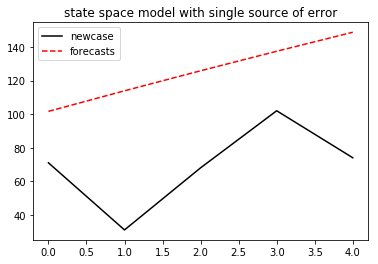

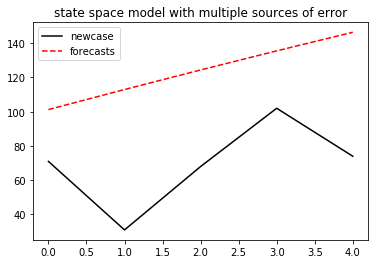

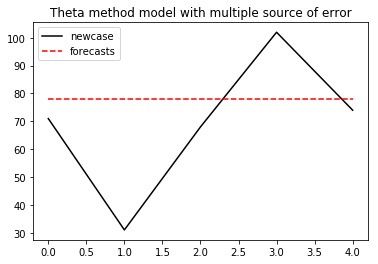

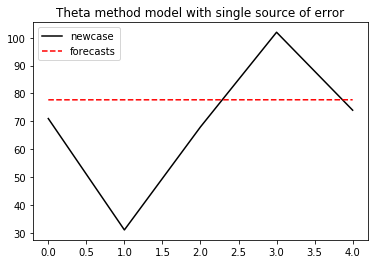

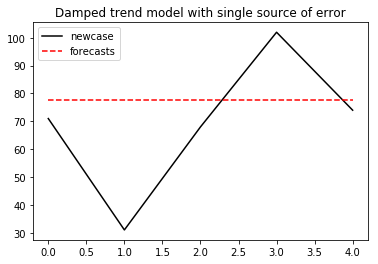

In [38]:
plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(newcaseKFMS,'r--',label='forecasts')
plt.legend()
plt.title("state space model with single source of error")
plt.show()

plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(newcaseKFSS,'r--',label='forecasts')
plt.legend()
plt.title("state space model with multiple sources of error")
plt.show()

plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(newcaseThetaMS,'r--',label='forecasts')
plt.legend()
plt.title("Theta method model with multiple source of error")
plt.show()

plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(newcaseThetaSS,'r--',label='forecasts')
plt.legend()
plt.title("Theta method model with single source of error")
plt.show()

plt.plot(newcase[(len(newcase)-5):len(newcase)],'black',label='newcase')
plt.plot(newcaseDampedSS,'r--',label='forecasts')
plt.legend()
plt.title("Damped trend model with single source of error")
plt.show()

In [36]:
# 上移一格
newcaseKFMS=ForecastKFMS(newcase,5)
newcaseKFSS=ForecastKFSS(newcase,5)
newcaseThetaMS=ForecastThetaMS(newcase,5)
newcaseThetaSS=ForecastThetaSS(newcase,5)
newcaseDampedSS=ForecastDampedSS(newcase,5)

可以看出，不做任何改进的state space 模型表现最差，其他三个模型直观上看不出区别，下面计算MASE和MAPE进行定量比较。

In [40]:
KFMS_MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseKFMS))/np.mean(abs(np.diff(x)))
KFMS_MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseKFMS)/
             (abs(newcaseKFMS)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
KFSS_MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseKFSS))/np.mean(abs(np.diff(x)))
KFSS_MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseKFSS)/
             (abs(newcaseKFSS)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
ThetaMS_MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseThetaMS))/np.mean(abs(np.diff(x)))
ThetaMS_MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseThetaMS)/
             (abs(newcaseThetaMS)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
ThetaSS_MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseThetaSS))/np.mean(abs(np.diff(x)))
ThetaSS_MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseThetaSS)/
             (abs(newcaseThetaSS)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
DampedSS_MASE=np.mean(abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseDampedSS))/np.mean(abs(np.diff(x)))
DampedSS_MAPE=np.mean(200*abs(newcase[(len(newcase)-5):len(newcase)+1]-newcaseDampedSS)/
             (abs(newcaseDampedSS)+abs(newcase[(len(newcase)-5):len(newcase)+1])))
print('KFMS_MASE=',KFMS_MASE)
print('KFMS_MAPE=',KFMS_MAPE)
print('KFSS_MASE=',KFSS_MASE)
print('KFSS_MAPE=',KFSS_MAPE)
print('ThetaMS_MASE=',ThetaMS_MASE)
print('ThetaMS_MAPE=',ThetaMS_MAPE)
print('ThetaSS_MASE=',ThetaSS_MASE)
print('ThetaSS_MAPE=',ThetaSS_MAPE)
print('DampedSS_MASE=',DampedSS_MASE)
print('DampedSS_MAPE=',DampedSS_MAPE)

KFMS_MASE= 0.344277289792
KFMS_MAPE= 61.2695148973
KFSS_MASE= 0.335488308734
KFSS_MAPE= 60.2938633899
ThetaMS_MASE= 0.112020137259
ThetaMS_MAPE= 28.163789449
ThetaSS_MASE= 0.111492139573
ThetaSS_MAPE= 28.0593189721
DampedSS_MASE= 0.111437129131
DampedSS_MAPE= 28.048305712


从中可以看出，表现最好的是Damped trend model， 表现最差的单噪声源的Kalman filter。